In [14]:
import numpy as np

grid_size = (5,5,5)
n_points = np.prod(grid_size)
params = np.zeros(np.prod(grid_size)*3)
for i, p in enumerate(np.ndindex(grid_size)):
    params[i] = p[2]
    params[n_points + i] = p[1]
    params[2*n_points + i] = p[0]

<AxesSubplot: >

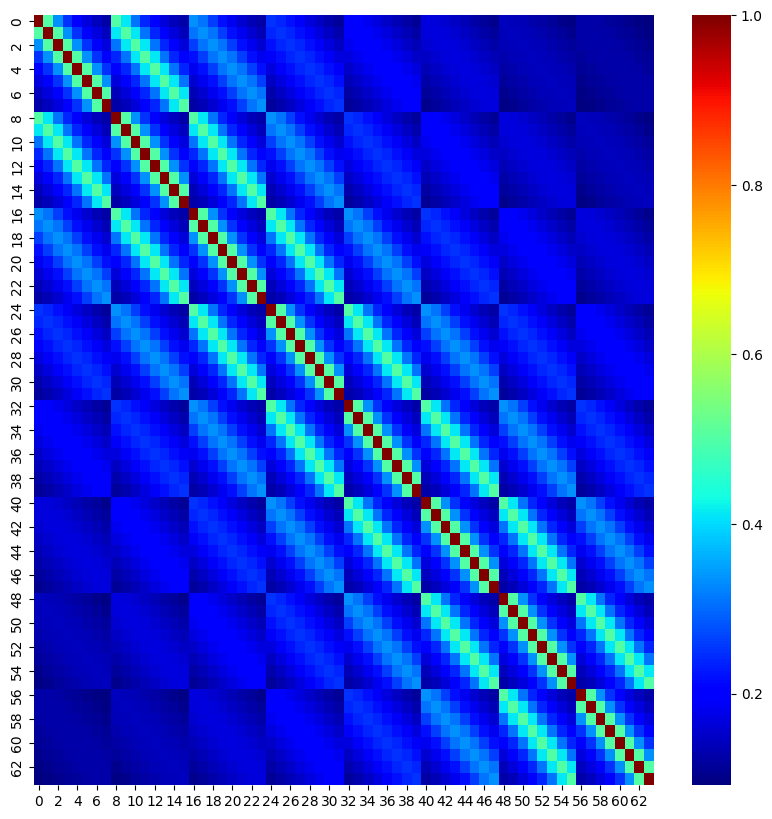

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x = np.loadtxt("similarities.txt")

plt.figure(figsize=(10,10))
sns.heatmap(x[:64, :64], cmap="jet")

In [17]:
x[0, 32]

0.2